## Домашнее задание 1
* Написать на PyTorch forward & backward полносвязного слоя без использования autograd
* Написать один-два адаптивных оптимизатора
* Решить задачу нахождения корней квадратного уравнения методом градиентного спуска

### Task 1

Find the roots of square equation by gradient descent

x ** 2 - 6 * x + 4 = 0

Загуглировал в процессе решения задачи следующие материалы:
https://towardsdatascience.com/polynomial-regression-gradient-descent-from-scratch-279db2936fe9
https://habr.com/ru/post/474602/

* возвести в квадрат
* посчитать производную
* надо начать движение от начальной точки в направлении антиградиента с заданным шагом
* x = x - lr * grad(x)
* всегда ли сойдемся за приемлемое количество шагов - *Ответ: в целом да. количество шагов обратно пропорционально lr, и перебирая величину lr можно прийти к оптимальному количеству шагов.*
* важна ли начальная точка - *Ответ: важна. Разобрался с графической интерпретацией. Нам нужно две начальные точки взять условно с разных концов параболы.*
* как найти второй корень - *Ответ: (и обсуждали это в чате) - два градиентных спуска.*
* как вляет ЛР - *Ответ: влиеяет на количество шагов.*

In [1]:
from sympy import symbols, diff, Poly
from sympy.plotting import plot

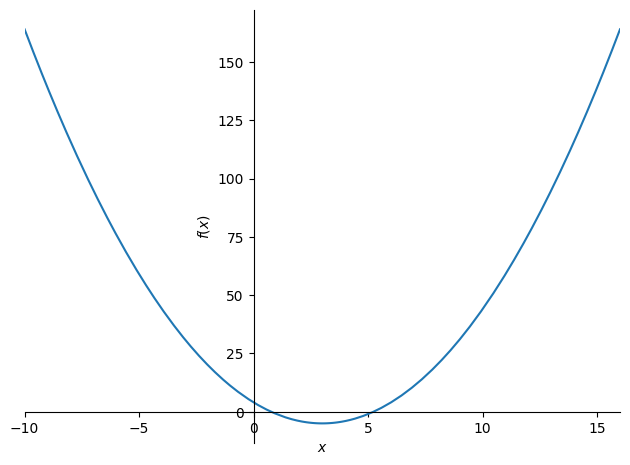

Poly(x**2 - 6*x + 4, x, domain='ZZ')

In [2]:
x,y = symbols('x y')
p = Poly(x**2-6*x+4)

plot(p.as_expr(), (x, -10, 16),xlim=(-10,16))
p

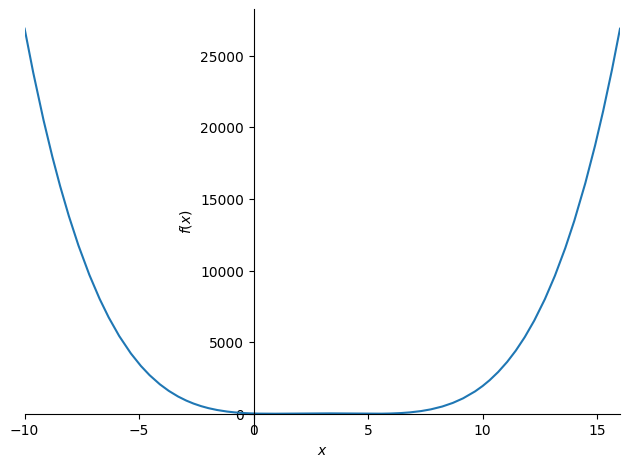

Poly(x**4 - 12*x**3 + 44*x**2 - 48*x + 16, x, domain='ZZ')

In [3]:
p_2= p**2
plot(p_2.as_expr(), (x, -10, 16),xlim=(-10,16))
p_2

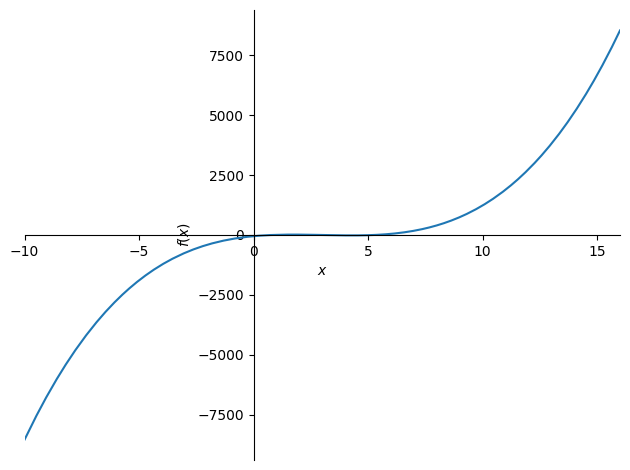

Poly(4*x**3 - 36*x**2 + 88*x - 48, x, domain='ZZ')

In [4]:
p_dff = diff(p_2)
plot(p_dff.as_expr(), (x, -10, 16),xlim=(-10,16))
p_dff

In [5]:
 # задаю learning rate
stop = False

In [6]:
#main loop of root search
lr = 0.0001
start_x = 10.0
iteration_count = 0
while iteration_count<10000:
    x_for_poly_p2 =  start_x - lr * p_dff.eval(x=start_x)
    y_for_p2 = p_2.eval(x=x_for_poly_p2)
    # print(f'Trying x value :{x_for_poly_p2}, got y: {y_for_p2}')
    if 0==y_for_p2:
        print(f'Found root of the equation: {x_for_poly_p2}, steps: {iteration_count}')
        break
    iteration_count+=1
    start_x = x_for_poly_p2

Found root of the equation: 5.23606803730052, steps: 4148


In [7]:
lr = 0.0001
start_x = -10.0
iteration_count = 0
while iteration_count<10000:
    x_for_poly_p2 =  start_x - lr * p_dff.eval(x=start_x)
    y_for_p2 = p_2.eval(x=x_for_poly_p2)
    # print(f'Trying x value :{x_for_poly_p2}, got y: {y_for_p2}')
    if 0==y_for_p2:
        print(f'Found root of the equation: {x_for_poly_p2}, steps: {iteration_count}')
        break
    iteration_count+=1
    start_x = x_for_poly_p2

Found root of the equation: 0.763932008519135, steps: 4529


### Task 2

Implement forward and backward pass for linear layer with sigmoid activation

In [8]:
import random
import torch
print(torch.version.__version__)

1.13.0


In [9]:
def sigmoid(x):
    return 1. / (1 + torch.exp(-x))

def sigmoid_backward(da, x):
    sig = sigmoid(x)
    
    return da * sig * (1 - sig)

def relu(x):
    return torch.tensor(torch.maximum(torch.tensor(0.), x))

def relu_backward(da, x):
    da = da.clone().detach()
    da[x <= 0] = 0;
    return da;

In [10]:
def mse_loss(t, y):
    return (t - y) ** 2

def d_mse_loss(t, y):
    return 2 * (y - t) 

In [11]:
class LinearLayer:
    def __init__(self, n_inp, n_out, activation='sigmoid'):
        self.w = torch.randn(n_out, n_inp) * 0.1
        self.b = torch.randn(n_out, 1) * 0.1
        if activation == 'sigmoid':
            self.activ = sigmoid
        elif activation == 'relu':
            self.activ = relu
        elif activation == 'None':
            self.activ = None
        else:
            raise Exception(f'Unknown activation "{activation}"')
        self._clear_state()

    def _clear_state(self):
        self.lin = None
        self.inp = None
        self.d_w = None
        self.d_b = None

    def forward(self, x):
        self.inp = x
        self.lin = torch.mm(self.w, x.float()) + self.b
        activ = self.activ(self.lin) if self.activ is not None else self.lin
        return activ

    def backward(self, grad): # grad = d L / d z    Dout 
        # grad * dz / d lin
        if self.activ == sigmoid:
            grad_lin = sigmoid_backward(grad, self.lin) 
        elif self.activ == relu:
            grad_lin = relu_backward(grad, self.lin)
        else:
            grad_lin = grad
        # grad_lin * d lin / d w 
        m = self.inp.shape[1]
        self.d_w = torch.mm(grad_lin, self.inp.T.float()) / m    # d_in dOut
        # grad_lin * d lin / d b 
        self.d_b = torch.sum(grad_lin, axis=1, keepdims=True) / m

        grad = torch.mm(self.w.T, grad_lin)

        return grad

# pred = model(x)
# loss = criterion(pred, target)
# grad = d loss / d pred
# model.backward(grad)

In [12]:
from typing import Tuple

class Model:
    def __init__(self, arch: Tuple[Tuple[int, int]], activation):
        self.layers = []
        for i, p in enumerate(arch):
            self.layers.append(
                LinearLayer(p[0], p[1], 
                            activation=activation if i < len(arch)-1 else 'None')
                )
        self._clear_state()
    
    def _clear_state(self):
        for l in self.layers:
            l._clear_state()

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        
        return x

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

        return grad 

### Task 3

Implement SGD Momentum optimizer

velocity = momentum * velocity - lr * gradient

w = w + velocity

In [13]:
#для одного слоя
class SGDMomentum:
    def __init__(self, model: LinearLayer, lr=0.001, momentum=0.99):
        self.lr = lr
        self.m = momentum
        self.model = model

        self.vel_w = torch.zeros_like(model.w)
        self.vel_b = torch.zeros_like(model.b)

    def step(self):
        self.vel_w = self.m * self.vel_w - self.lr * self.model.d_w
        self.vel_b = self.m * self.vel_b - self.lr * self.model.d_b

        self.model.w += self.vel_w
        self.model.b += self.vel_b

        


In [14]:
#для всей модели
class SGDMomentum:
    def __init__(self, model: Model, lr= 0.0001, momentum=0.0):
        self.model = model
        self.lr = lr
        self.m = momentum
        self.vel = [[torch.zeros_like(layer.w), 
                     torch.zeros_like(layer.b)] for layer in model.layers]

    def step(self):
        for i, layer in enumerate(self.model.layers):
            self.vel[i][0] = self.vel[i][0] * self.m - self.lr * layer.d_w 
            self.vel[i][1] = self.vel[i][1] * self.m - self.lr * layer.d_b 
            layer.w += self.vel[i][0]
            layer.b += self.vel[i][1]
    
    def zero_grad(self):
        self.model._clear_state()

In [15]:
x = torch.FloatTensor(2000).uniform_(-2,2)
y = x**2 + random.random()*0.1

In [16]:
def run_model(activation: str):
    print(f'Activation function : {activation}')
    model = Model(((1, 100), (100, 1)), activation)
    optim = SGDMomentum(model)
    for e in range(20):
        for i, (val, t) in enumerate(zip(x, y)):
            optim.zero_grad()
            pred = model.forward(torch.tensor([[val]]))
            loss = mse_loss(t, pred)
            grad = d_mse_loss(t, pred)
            model.backward(grad)
            optim.step()

        print(e, model.forward(torch.tensor([[1]])), model.forward(torch.tensor([[2]])), model.forward(torch.tensor([[-1]])), model.forward(torch.tensor([[-2]])))

In [17]:
run_model('relu')

Activation function : relu


/var/folders/m5/pv26hd813_bbqw43lz3r1n1rhpvc8t/T/ipykernel_35493/1364784206.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.maximum(torch.tensor(0.), x))


0 tensor([[0.7510]]) tensor([[1.0622]]) tensor([[0.7674]]) tensor([[1.0031]])
1 tensor([[1.1860]]) tensor([[1.6888]]) tensor([[1.1889]]) tensor([[1.5959]])
2 tensor([[1.3588]]) tensor([[2.0001]]) tensor([[1.3571]]) tensor([[1.9190]])
3 tensor([[1.4232]]) tensor([[2.1788]]) tensor([[1.4367]]) tensor([[2.1186]])
4 tensor([[1.4483]]) tensor([[2.3097]]) tensor([[1.4735]]) tensor([[2.2654]])
5 tensor([[1.4591]]) tensor([[2.4223]]) tensor([[1.4920]]) tensor([[2.3869]])
6 tensor([[1.4639]]) tensor([[2.5244]]) tensor([[1.5013]]) tensor([[2.4931]])
7 tensor([[1.4652]]) tensor([[2.6178]]) tensor([[1.5051]]) tensor([[2.5879]])
8 tensor([[1.4644]]) tensor([[2.7036]]) tensor([[1.5053]]) tensor([[2.6731]])
9 tensor([[1.4617]]) tensor([[2.7817]]) tensor([[1.5030]]) tensor([[2.7498]])
10 tensor([[1.4577]]) tensor([[2.8527]]) tensor([[1.4990]]) tensor([[2.8189]])
11 tensor([[1.4528]]) tensor([[2.9169]]) tensor([[1.4939]]) tensor([[2.8811]])
12 tensor([[1.4473]]) tensor([[2.9748]]) tensor([[1.4881]]) te

In [18]:
run_model('sigmoid')

Activation function : sigmoid
0 tensor([[1.2810]]) tensor([[1.2438]]) tensor([[1.3557]]) tensor([[1.3926]])
1 tensor([[1.2822]]) tensor([[1.2461]]) tensor([[1.3546]]) tensor([[1.3904]])
2 tensor([[1.2833]]) tensor([[1.2482]]) tensor([[1.3535]]) tensor([[1.3882]])
3 tensor([[1.2842]]) tensor([[1.2501]]) tensor([[1.3525]]) tensor([[1.3863]])
4 tensor([[1.2851]]) tensor([[1.2519]]) tensor([[1.3516]]) tensor([[1.3844]])
5 tensor([[1.2860]]) tensor([[1.2537]]) tensor([[1.3507]]) tensor([[1.3827]])
6 tensor([[1.2868]]) tensor([[1.2552]]) tensor([[1.3499]]) tensor([[1.3811]])
7 tensor([[1.2875]]) tensor([[1.2567]]) tensor([[1.3491]]) tensor([[1.3796]])
8 tensor([[1.2882]]) tensor([[1.2581]]) tensor([[1.3484]]) tensor([[1.3782]])
9 tensor([[1.2889]]) tensor([[1.2594]]) tensor([[1.3477]]) tensor([[1.3769]])
10 tensor([[1.2895]]) tensor([[1.2606]]) tensor([[1.3471]]) tensor([[1.3757]])
11 tensor([[1.2900]]) tensor([[1.2618]]) tensor([[1.3465]]) tensor([[1.3745]])
12 tensor([[1.2906]]) tensor([[1